## Kameron Lightheart 
## Final Collaborative Assignment
## April 21, 2020

In [ ]:
# data exploration
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# functions to fit CPDs
import os
from statsmodels.tools.tools import add_constant
import causalgraphicalmodels as cgm
os.environ["PATH"] += r'C:\Program Files (x86)\graphviz-2.38\bin;'
os.environ["PATH"] += r'C:\Program Files (x86)\graphviz-2.38\bin\dot.exe;'

# types of CPDs
from statsmodels.discrete.discrete_model import MNLogit
import statsmodels.regression.linear_model as sm
from scipy.stats import norm, t


# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split

# Data Exploration

In [8]:
# Create DF
df = pd.read_csv('final upload/graduate-admissions (1)/Admission_Predict_Ver1.1.csv')
df.drop(columns='Serial No.', inplace=True)
df.columns = ['gre', 'toefl', 'univ_rating', 'sop', 'lor', 'cgpa', 'research', 'prob_admit']
df.sample()

,gre,toefl,univ_rating,sop,lor,cgpa,research,prob_admit
475,300,101,3,3.5,2.5,7.88,0,0.59


# Functions to Fit CPDs

In [9]:
# The following 4 train and fit functions are used in the construct_causal_model function at the end
def _construct_column_attributes_dict(df):
    col_attrs = dict()
    discrete_max_vals = 20

    for col in df.columns:
        options =  df[col].unique()
        ncols = len(options)

        discrete = False
        if len(options) < discrete_max_vals:
            discrete = True

        col_attrs[col] = dict()
        col_attrs[col]['discrete'] = discrete
        if discrete:
            col_attrs[col]['options'] = options

            # fit discrete probability table
            p = np.zeros(len(options))
            for i, opt in enumerate(options):
                cur_p = len(df[df[col]==opt])/len(df)
                p[i] = cur_p
            col_attrs[col]['p'] = p

        else:
            col_attrs[col]['options'] = (df[col].min(), df[col].max()) # upper and lower bounds if continuous

        col_attrs[col]['dtype'] = type(df[col][0])
        
    return col_attrs
    

# define methods for fitting discrete and continuous models, sampling from discrete and continuous distributions, and
# constructing a causal model from those using 
def _train_model(model_class, X_columns, y_col, df, col_attrs):
    y_train, X_train = df[y_col].to_numpy(), df[X_columns].to_numpy()
    X_train = add_constant(X_train)
    model = model_class(y_train, X_train).fit()
    
    def evaluate_model(n_samples, *columns):
        X = np.column_stack((col for col in columns))
        #X = add_constant(X) # for some reason this line doesn't work occasionally
        x0 = np.ones((X.shape[0], X.shape[1]+1))
        x0[:,1:] = X
        
        if col_attrs[y_col]['discrete']:
            return col_attrs[y_col]['options'][np.argmax(model.predict(x0), axis=1)]
        else:
            mn, mx = col_attrs[y_col]['options']
            return np.clip(model.predict(x0), mn, mx)
            
    return evaluate_model
    
def _fit_discrete_dist(y_col, col_attrs):
    if not col_attrs[y_col]['discrete']:
        raise ValueError(f'The provided column {y_col} has more than {discrete_max_vals}\n' + 
                         f'distinct values and thus can not be samples from in this way.')
        
    def sample(n_samples):
        return np.random.choice(size=n_samples, a=col_attrs[y_col]['options'], p=col_attrs[y_col]['p'])
        
    return sample

def _fit_continuous_dist(y_col, distribution, df, col_attrs):
    """fits the specified distribution. This should work with most distributions from scipy.stats, but not all
    because some don't have a fit function or the parameters may not line up right."""
    # fit dist to data
    params = distribution.fit(df[y_col].to_numpy())

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    
    def sample(n_samples):
        mn, mx = col_attrs[y_col]['options']
        return np.clip(distribution(loc=loc, scale=scale, *arg).rvs(n_samples), mn, mx)
    
    return sample

def construct_causal_model(df, model_type_dict, graphical_model, models_dict_name):
    col_attrs = _construct_column_attributes_dict(df)
    
    nodes = graphical_model.dag.nodes
    models = dict()
    
    exec_str_parts = dict()
    
    edges = graphical_model.dag.edges
    for node in nodes:
        # get parents of current node
        parents = []
        for edge in edges:
            parent, child = edge
            if child is node:
                parents += [parent]
                
        if len(parents) > 0:
            input_names = ''
            for col in parents:
                input_names += col + ', '
            input_names = input_names[:-2]
            
            models[node] = _train_model(model_type_dict[node], parents, node, df, col_attrs)
            #exec_str_parts[node] = f"models[node] = lambda n_samples, {input_names}: models[node](n_samples, {input_names})"
            exec_str_parts[node] = f"'{node}': lambda n_samples, {input_names}: {models_dict_name}['{node}'](n_samples, {input_names})"
            
        else:
            if col_attrs[node]['discrete']:
                models[node] = _fit_discrete_dist(node, col_attrs)
                #models[node] = lambda n_samples: models[node](n_samples)
                exec_str_parts[node] = f"'{node}': lambda n_samples: {models_dict_name}['{node}'](n_samples)"
                
            else:
                models[node] = _fit_continuous_dist(node, model_type_dict[node], df, col_attrs)
                #models[node] = lambda n_samples: models[node](n_samples)
                exec_str_parts[node] = f"'{node}': lambda n_samples: {models_dict_name}['{node}'](n_samples)"
    
    
    exec(f'global {models_dict_name}; {models_dict_name} = models', globals(), locals()) # because they expect the models to be globally defined
    SCM = None
    local_dict = locals()
    
    execstr = "SCM = cgm.StructuralCausalModel({"
    for i, node in enumerate(nodes):
        if i > 0:
            execstr += '    '
        execstr += exec_str_parts[node]
        if i == len(nodes) - 1:
            execstr += '})'
        else:
            execstr += ',\n'
    #print(execstr)

    exec(execstr, globals(), local_dict)
    SCM = local_dict['SCM']
    
    return SCM

# Map 2 (source: Becca)

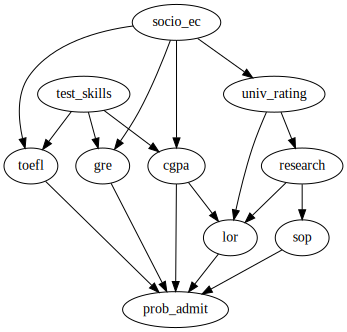

In [15]:
grad_school2 =  cgm.CausalGraphicalModel(
    nodes=["univ_rating", "cgpa", "gre", "toefl", "research", "lor", "sop","prob_admit",
           "test_skills", "socio_ec"],
    edges=[
        ("cgpa", "prob_admit"), 
        ("gre", "prob_admit"),
        ("toefl", "prob_admit"),
        ("sop", "prob_admit"),
        ("lor", "prob_admit"),
        ("univ_rating", "research"), 
        ("univ_rating", "lor"),
        ("research", "lor"), 
        ("research", "sop"), 
        ("cgpa","lor"),
        ("test_skills","gre"),
        ("test_skills","toefl"),
        ("test_skills","cgpa"),
        ("socio_ec", "univ_rating"),
        ("socio_ec", "cgpa"),
        ("socio_ec", "gre"),
        ("socio_ec", "toefl")],
        )

grad_school2.draw()

In [16]:
# theoretically these would be calculated in some meaningful way that will provide meaninful information to the
# cpd functions of their children, but I just sample them here to test that doing so works with my defined functions above.
df['test_skills'] = pd.Series(norm(loc=50, scale=10).rvs(len(df)))
df['socio_ec'] = pd.Series(norm(loc=10, scale=1).rvs(len(df)))

df.sample(5)

,gre,toefl,univ_rating,sop,lor,cgpa,research,prob_admit,test_skills,socio_ec
144,325,112,2,3.0,3.5,8.96,1,0.80,53.211031,10.173272
289,313,109,3,4.0,3.5,9.00,0,0.79,58.737241,11.763028
49,327,111,4,3.0,4.0,8.40,1,0.78,39.531013,12.280982
5,330,115,5,4.5,3.0,9.34,1,0.90,42.294111,10.268181
258,326,102,4,5.0,5.0,8.76,1,0.77,49.379700,9.651803


In [18]:
n_samples = 10000
ds = grad_model2.sample(n_samples)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


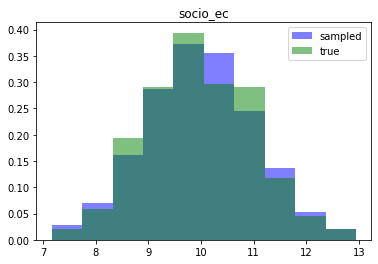

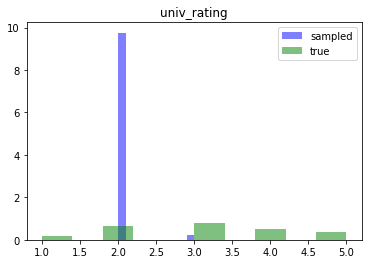

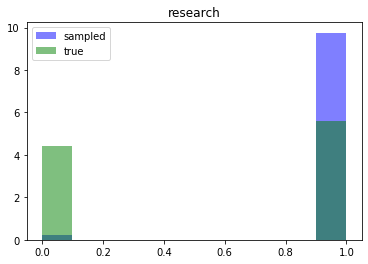

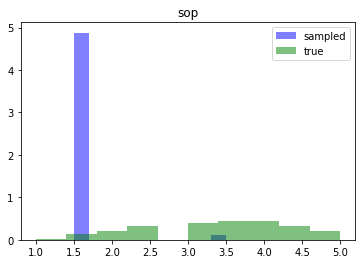

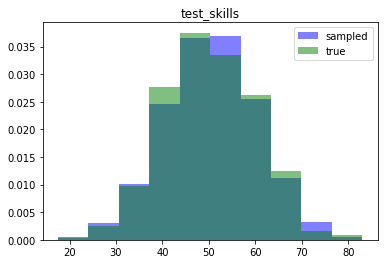

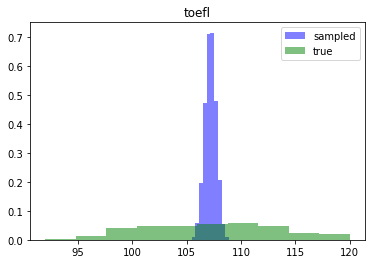

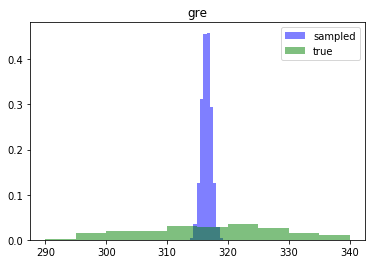

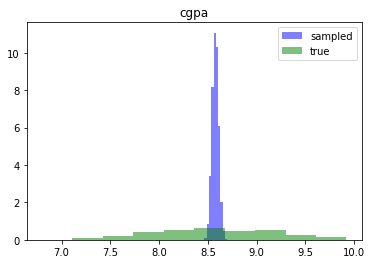

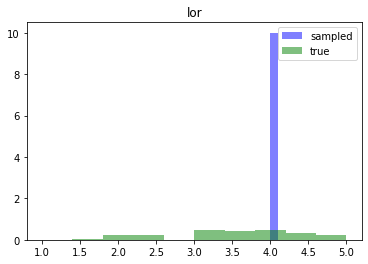

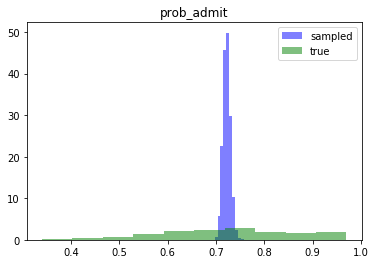

In [19]:
for col in ds.columns:
    plt.hist(ds[col].to_numpy(), alpha=.5, color='blue', label='sampled', density=True)
    plt.hist(df[col].to_numpy(), alpha=.5, color='green', label='true', density=True)
    plt.legend()
    plt.title(col)
    plt.show()

In [20]:
grad_school2.get_all_independence_relationships()

[('sop', 'lor', {'research'}),
 ('sop', 'lor', {'research', 'toefl'}),
 ('sop', 'lor', {'gre', 'research'}),
 ('sop', 'lor', {'research', 'univ_rating'}),
 ('sop', 'lor', {'research', 'socio_ec'}),
 ('sop', 'lor', {'cgpa', 'research'}),
 ('sop', 'lor', {'research', 'test_skills'}),
 ('sop', 'lor', {'gre', 'research', 'toefl'}),
 ('sop', 'lor', {'research', 'toefl', 'univ_rating'}),
 ('sop', 'lor', {'research', 'socio_ec', 'toefl'}),
 ('sop', 'lor', {'cgpa', 'research', 'toefl'}),
 ('sop', 'lor', {'research', 'test_skills', 'toefl'}),
 ('sop', 'lor', {'gre', 'research', 'univ_rating'}),
 ('sop', 'lor', {'gre', 'research', 'socio_ec'}),
 ('sop', 'lor', {'cgpa', 'gre', 'research'}),
 ('sop', 'lor', {'gre', 'research', 'test_skills'}),
 ('sop', 'lor', {'research', 'socio_ec', 'univ_rating'}),
 ('sop', 'lor', {'cgpa', 'research', 'univ_rating'}),
 ('sop', 'lor', {'research', 'test_skills', 'univ_rating'}),
 ('sop', 'lor', {'cgpa', 'research', 'socio_ec'}),
 ('sop', 'lor', {'research', 'soci

# Do Calculus Applied to Model 2
Now we proceed by examining what happens when we intervene on the model. For instance, if we get a student involved in undergraduate research, how much more or less likely are they to be accepted into grad school? Well we intervene on the "research" node as shown below.

P(test_skills)P(socio_ec)P(toefl|test_skills,socio_ec)P(gre|test_skills,socio_ec)P(cgpa|test_skills,socio_ec)P(univ_rating|socio_ec)P(sop|do(research))P(lor|univ_rating,cgpa,do(research))P(prob_admit|cgpa,gre,toefl,lor,sop)


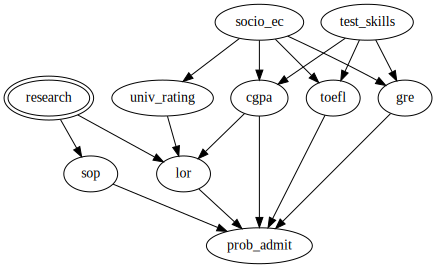

In [21]:
grad_school2_do = grad_school2.do("research")
print(grad_school2_do.get_distribution())

grad_school2_do.draw()

In [30]:
# Get lists of back door possibilites between research and prob_admit
for set1 in grad_school2.get_all_backdoor_adjustment_sets("research", "prob_admit"):
    nodes = []
    for set2 in set1:
        nodes.append(set2)
    print(nodes)

['univ_rating', 'cgpa', 'test_skills', 'gre']
['univ_rating', 'socio_ec', 'test_skills', 'gre']
['univ_rating', 'socio_ec', 'test_skills']
['univ_rating', 'gre']
['univ_rating']
['univ_rating', 'gre', 'test_skills', 'toefl']
['univ_rating', 'socio_ec', 'test_skills', 'toefl']
['univ_rating', 'socio_ec']
['univ_rating', 'cgpa']
['gre', 'toefl', 'univ_rating', 'socio_ec', 'cgpa']
['gre', 'toefl', 'univ_rating', 'socio_ec', 'test_skills']
['univ_rating', 'socio_ec', 'test_skills', 'cgpa']
['socio_ec', 'univ_rating', 'gre', 'toefl']
['univ_rating', 'socio_ec', 'cgpa', 'gre']
['gre', 'univ_rating', 'socio_ec', 'cgpa', 'test_skills']
['gre', 'toefl', 'univ_rating', 'cgpa', 'test_skills']
['univ_rating', 'toefl']
['univ_rating', 'test_skills']
['univ_rating', 'socio_ec', 'cgpa', 'toefl']
['univ_rating', 'test_skills', 'cgpa']
['univ_rating', 'test_skills', 'gre']
['univ_rating', 'test_skills', 'toefl']
['univ_rating', 'socio_ec', 'toefl']
['univ_rating', 'socio_ec', 'gre']
['gre', 'toefl', 'u

In [54]:
from causalinference import CausalModel

def estimate_ate(dataset, adjustment_set=None, method="ols"):
    """
    Estimate the ATE of X on Y from from dataset when 
    adjusting using adjustment_set.
    
    Arguments
    ---------
    dataset: pd.DateFrame
        dataframe of observations
        
    adjustment_set: iterable of variables or None
    
    method: str
        adjustment method to use.    
    """
    
    if adjustment_set is None:
        y0 = dataset.loc[lambda df: df.research == 0]['prob_admit'].mean()
        y1 = dataset.loc[lambda df: df.research == 1]['prob_admit'].mean()
        
        y0_var = dataset.loc[lambda df: df.research == 0]['prob_admit'].var()
        y1_var = dataset.loc[lambda df: df.research == 1]['prob_admit'].var()
        
        y0_n = dataset.loc[lambda df: df.research == 0].shape[0]
        y1_n = dataset.loc[lambda df: df.research == 1].shape[0]
        
        return {
            "ate": y1 - y0,
            "ate_se": 2 * np.sqrt(y0_var/y0_n + y1_var/y1_n)
        }

    cm = CausalModel(
        Y=dataset['prob_admit'].values, 
        D=dataset['research'].values, 
        X=dataset[adjustment_set].values
    )

    cm.est_via_ols()
#     cm.est_via_matching()
#     cm.est_propensity_s()
#     cm.est_via_weighting()

#     cm.stratify_s()
#     cm.est_via_blocking()
    
    results = {
        "ate": cm.estimates[method]["ate"],
        "ate_se": cm.estimates[method]["ate_se"]
    }

    return results

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


no_adjustment                                               	-52537908689.96521
adjustment_univ_rating_cgpa_test_skills_gre                 	-47137962066.266014
adjustment_univ_rating_socio_ec_test_skills_gre             	-8414362993.393513
adjustment_univ_rating_socio_ec_test_skills                 	-19.677619876858017
adjustment_univ_rating_gre                                  	-19.48547903916654
adjustment_univ_rating                                      	-18.7673211194062
adjustment_univ_rating_gre_test_skills_toefl                	-0.5723018841248918
adjustment_univ_rating_socio_ec_test_skills_toefl           	-0.015910193185310173
adjustment_univ_rating_socio_ec                             	0.07168050740697186
adjustment_univ_rating_cgpa                                 	0.07844384568288328
adjustment_gre_toefl_univ_rating_socio_ec_cgpa              	0.10306241012606325
adjustment_gre_toefl_univ_rating_socio_ec_test_skills       	0.12511481419122614
adjustment_univ_rating_socio_ec

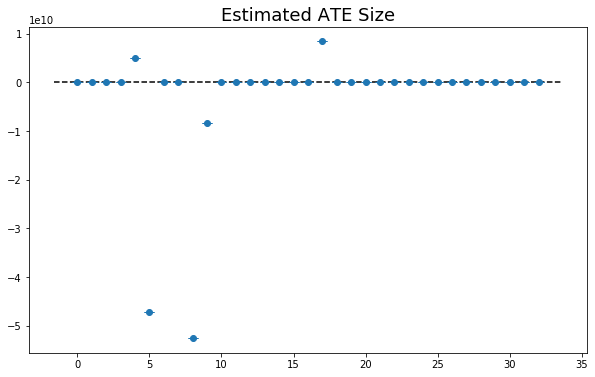

In [80]:
n_samples = 10000

sample = grad_model2.sample(n_samples)

# this allows us to generate samples from an interventional distribution
# where the value of X is assigned randomly as in an A/B test.
intervention = (
    grad_model2
    .do("research")
    .sample(
        n_samples=1000000, 
        set_values={"research": np.random.binomial(p=0.5, n=1, size=1000000)})
)

true_ate = estimate_ate(intervention)["ate"]

results = {"no_adjustment": estimate_ate(sample)}
# generate results for a number of different adjustment sets
for set1 in grad_school2.get_all_backdoor_adjustment_sets("research", "prob_admit"):
    nodes = []
    for set2 in set1:
        nodes.append(set2)
    results['adjustment_' + '_'.join(nodes)] = estimate_ate(sample, nodes)

# plot the results
x_label = list(results.keys())
x = np.arange(len(x_label))
y = [results[l]["ate"] for l in x_label]
yerr = [results[l]["ate_se"] for l in x_label]

plt.figure(figsize=(10,6))
plt.errorbar(x=x, y=y, yerr=yerr, linestyle="none", capsize=5, marker="o")
# plt.xticks(x, x_label, rotation=45, fontsize=16)
plt.title("Estimated ATE Size", fontsize=18)
xmin, xmax = plt.xlim()
plt.hlines(true_ate, xmin, xmax, linestyles="dashed")

y_sorted = sorted(y)

for i in range(len(x)):
    print(x_label[i].ljust(60) + "\t" + str(y_sorted[i]))

Conclusion, from these ate (average treatment effect) values, we can see that a majority of the options matched the true value. This was expected because I used the options from the "get_all_backdoor_adjustment_sets("research", "prob_admit")" function. Also it was expected that using nothing would be way off of the true value. What was not expected were the outliers way off from the true value because again I only used actual back doors for the options. 

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


no_adjustment                                               	-111403963425.60335
adjustment_lor_research_gre_socio_ec_test_skills            	-111403953832.83965
adjustment_lor_research_gre_univ_rating_socio_ec            	-101764985176.29297
adjustment_socio_ec_lor_research_cgpa                       	-101019752824.01207
adjustment_research_toefl_gre_univ_rating_socio_ec_cgpa     	-60559811108.578476
adjustment_research_toefl                                   	-60559417160.06291
adjustment_lor_research_toefl_cgpa_test_skills              	-55216866537.853294
adjustment_lor_gre_univ_rating_socio_ec_cgpa_test_skills    	-55131380770.95611
adjustment_toefl_lor_research_gre                           	-7769676382.409209
adjustment_lor_toefl_gre_univ_rating_cgpa_test_skills       	-7679849236.114644
adjustment_univ_rating_socio_ec_research                    	-3739683705.018515
adjustment_research_toefl_univ_rating_socio_ec_cgpa_test_skills	-3707008343.050405
adjustment_lor_research_toefl_g

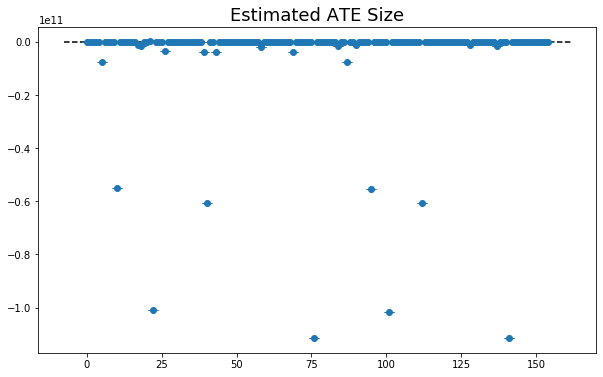

In [84]:
n_samples = 10000

sample = grad_model2.sample(n_samples)

# this allows us to generate samples from an interventional distribution
# where the value of X is assigned randomly as in an A/B test.
intervention = (
    grad_model2
    .do("sop")
    .sample(
        n_samples=1000000, 
        set_values={"sop": np.random.binomial(p=0.5, n=1, size=1000000)})
)

true_ate = estimate_ate(intervention)["ate"]

results = {"no_adjustment": estimate_ate(sample)}
# generate results for a number of different adjustment sets
for set1 in grad_school2.get_all_backdoor_adjustment_sets("sop", "prob_admit"):
    nodes = []
    for set2 in set1:
        nodes.append(set2)
    results['adjustment_' + '_'.join(nodes)] = estimate_ate(sample, nodes)

# plot the results
x_label = list(results.keys())
x = np.arange(len(x_label))
y = [results[l]["ate"] for l in x_label]
yerr = [results[l]["ate_se"] for l in x_label]

plt.figure(figsize=(10,6))
plt.errorbar(x=x, y=y, yerr=yerr, linestyle="none", capsize=5, marker="o")
# plt.xticks(x, x_label, rotation=45, fontsize=16)
plt.title("Estimated ATE Size", fontsize=18)
xmin, xmax = plt.xlim()
plt.hlines(true_ate, xmin, xmax, linestyles="dashed")

y_sorted = sorted(y)

for i in range(len(x)):
    print(x_label[i].ljust(60) + "\t" + str(y_sorted[i]))

I ran into problems trying to run the same code on other nodes as interventions like "gre" or "toefl" or "lor" because of singular matrix errors. I finally found only one other that would work which was "sop" (Statement of Purpose). This ATE graph was more interesting since about half of the values were way off when I used only valid back door nodes as inputs. 

## My contributions
#### I started with Michael Nelson's notebook and worked through some of the ideas from the blog post about do calculus and causal inference. I agreed more with Becca's model, so that is the model I focused on. 

#### I spend 8 hours in total going through work done previously, reading blog posts, adding new code and troubleshooting errors. 